In [2]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose ,Concatenate, Add
from keras.models import Model
from keras import optimizers
from keras import backend as K
from tensorflow import keras
from keras.callbacks import TensorBoard
import tensorflow as tf
from SSIM_PIL import compare_ssim as ssim
from PIL import Image
import os, glob
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
import argparse
import imutils
import cv2
import numpy as np
from scipy import signal

2023-08-18 15:56:56.236784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
# input_img = Input(shape=(256, 256, 1))  
# # Encode-----------------------------------------------------------
# x = Conv2D(32, (4, 4), strides=2 , activation='relu', padding='same')(input_img)
# x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# encoded = Conv2D(100, (8, 8), strides=1, padding='same')(x)
# # Decode---------------------------------------------------------------------
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(encoded)
# x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = UpSampling2D((4, 4))(x)
# x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(x)

In [3]:
input_img = Input(shape=(1024, 1024, 1))  
# Encode-----------------------------------------------------------
x = Conv2D(32, (4, 4), strides=2 , activation='relu', padding='same')(input_img)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
encoded = Conv2D(256, (8, 8), strides=1, padding='same')(x)
# Decode---------------------------------------------------------------------
x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(encoded)
x = Conv2D(256, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2DTranspose(256, (4,4), padding='same', strides=(2, 2))(x)
x = Conv2D(128, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(128, (4,4), padding='same', strides=(2, 2))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (4,4), padding='same', strides=(2, 2))(x)
x = Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (4,4), padding='same', strides=(2, 2))(x)
x = Conv2D(64, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (4,4), padding='same', strides=(2, 2))(x)
x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (4,4), padding='same', strides=(2, 2))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (4,4), padding='same', strides=(2, 2))(x)
x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(16, (4,4), padding='same', strides=(2, 2))(x)
decoded = Conv2D(1, (8, 8), activation='sigmoid', padding='same')(x)

2023-08-18 15:57:01.736047: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
#ssim loss function
def ssim_loss(y_true,y_pred):
    return 1-tf.reduce_mean(tf.image.ssim(y_true,y_pred,1.0))

def mse_loss(y_true, y_pred):
    return tf.reduce_mean((y_pred-y_true)**2)

In [5]:
# MODEL SUMMARY---------------------------------------------------------------------
autoencoder = Model(input_img, decoded)
# enc = ResUnetPlusPlus()
# autoencoder = enc.build_model()
adam = keras.optimizers.legacy.Adam(learning_rate=0.0002, decay=0.00001)
autoencoder.compile(optimizer='adam', loss= ssim_loss)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024, 1024, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 32)      544       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      16416     
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      32832     
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       131200

In [6]:

# TRAINING MODEL WITH OUR Own Image Directory---------------------------------------
img_dir = (r"/home/pratyush-g/Documents/MvTech Dataset/carpet/train/good/")
img_files = glob.glob(img_dir + "*.png")
# Setting Image Properties
width = 1024
height = 1024
pixels = width * height * 1 # gray scale 

# Load Image 

x = []

for i, f in enumerate(img_files):
    img = Image.open(f)
#   img = img.convert("RGB")
    img = img.convert("L") # gray scale
    img = img.resize((width,height), 1)
    data = np.asarray(img)
    
    x.append(data)
    if i % 100 == 0:
        print(i, "\n", data)

x = np.array(x)
(x_train, x_test) = train_test_split(x, train_size=0.8, shuffle=False, test_size=0.2, random_state=0)

img_list = (x_train, x_test)
np.save("./obj.npy", img_list)
print("OK", len(x)) 

# change to float32
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1024, 1024, 1))  
x_test = np.reshape(x_test, (len(x_test), 1024, 1024, 1)) 


0 
 [[ 13  14  14 ...  65  63  59]
 [ 13  14  14 ...  68  64  62]
 [ 13  13  15 ...  77  73  68]
 ...
 [ 80  91 102 ...  68  70  67]
 [ 77  86  96 ...  71  70  68]
 [ 69  78  87 ...  77  79  80]]
100 
 [[ 64  51  47 ...  87  93  93]
 [ 63  51  45 ...  84  90  93]
 [ 64  51  43 ...  81  88  92]
 ...
 [102 109 109 ...  64  62  63]
 [ 98 109 115 ...  67  66  68]
 [ 97 105 117 ...  69  70  71]]
200 
 [[ 72  80  84 ...  55  55  49]
 [ 70  79  86 ...  51  52  47]
 [ 68  79  87 ...  50  49  46]
 ...
 [ 98 104 107 ...  74  79  81]
 [ 81  80  80 ...  74  82  85]
 [ 71  64  60 ...  59  65  68]]


/home/pratyush-g/miniconda3/envs/PratGaur/lib/python3.11/site-packages/numpy/lib/npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


OK 280


In [7]:
#fit model
history = autoencoder.fit(x_train, x_train,
                epochs= 50,
                batch_size=16,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/50
14/14 [==============================] - 1077s 77s/step - loss: 0.8008 - val_loss: 0.7955
Epoch 2/50
14/14 [==============================] - 893s 64s/step - loss: 0.8233 - val_loss: 0.7954
Epoch 3/50
14/14 [==============================] - 898s 64s/step - loss: 0.7499 - val_loss: 0.7068
Epoch 4/50
14/14 [==============================] - 886s 64s/step - loss: 0.6590 - val_loss: 0.6379
Epoch 5/50
14/14 [==============================] - 1006s 73s/step - loss: 0.6321 - val_loss: 0.6249
Epoch 6/50
14/14 [==============================] - 1029s 74s/step - loss: 0.6244 - val_loss: 0.6240
Epoch 7/50
14/14 [==============================] - 10315s 77s/step - loss: 0.6203 - val_loss: 0.6130
Epoch 8/50
14/14 [==============================] - 1111s 80s/step - loss: 0.6115 - val_loss: 0.6057
Epoch 9/50
14/14 [==============================] - 1125s 81s/step - loss: 0.6050 - val_loss: 0.5989
Epoch 10/50
14/14 [==============================] - 1132s 81s/step - loss: 0.6052 - val_loss

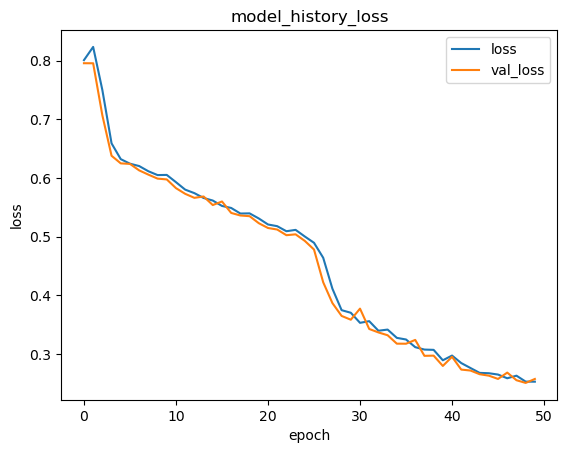

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_history_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'],loc='upper right')
plt.show()

In [9]:
autoencoder.save('/home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/Magnetic_Tile_AutoEnc_SSIm_UpSampling2D_carpet/')

2023-08-19 10:26:26.218962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,256]
	 [[{{node inputs}}]]
2023-08-19 10:26:26.238355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,128]
	 [[{{node inputs}}]]
2023-08-19 10:26:26.259635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,?,?,64]
	 [[{{node inputs}}]]
2023-

INFO:tensorflow:Assets written to: /home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/Magnetic_Tile_AutoEnc_SSIm_UpSampling2D_carpet/assets


INFO:tensorflow:Assets written to: /home/pratyush-g/Documents/Defect_Detection_Autoencoders/saved models/Magnetic_Tile_AutoEnc_SSIm_UpSampling2D_carpet/assets


In [10]:

def cal_ssim(img1, img2):
    
    K = [0.01, 0.03]
    L = 255
    kernelX = cv2.getGaussianKernel(11, 1.5)
    window = kernelX * kernelX.T
     
    M,N = np.shape(img1)

    C1 = (K[0]*L)**2
    C2 = (K[1]*L)**2
    img1 = np.float64(img1)
    img2 = np.float64(img2)
 
    mu1 = signal.convolve2d(img1, window, 'valid')
    mu2 = signal.convolve2d(img2, window, 'valid')
    
    mu1_sq = mu1*mu1
    mu2_sq = mu2*mu2
    mu1_mu2 = mu1*mu2
    
    
    sigma1_sq = signal.convolve2d(img1*img1, window, 'valid') - mu1_sq
    sigma2_sq = signal.convolve2d(img2*img2, window, 'valid') - mu2_sq
    sigma12 = signal.convolve2d(img1*img2, window, 'valid') - mu1_mu2
   
    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
    mssim = np.mean(ssim_map)
    return mssim,ssim_map


In [11]:
def ssim_seg(ori_img, re_img):
   
    # convert the images to grayscale
    if len(ori_img.shape) == 3:
        ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2GRAY)
    if len(re_img.shape) == 3:
        re_img = cv2.cvtColor(re_img, cv2.COLOR_BGR2GRAY)
    (s, s_map) = cal_ssim(ori_img, re_img)
    #(s, s_map) = structural_similarity(ori_img, re_img, full=True,multichannel=True)
    s      = np.clip(s_map, 0, 1)
    return s_map

def seg_mask(s_map, threshold=125):
    s_map = (s_map * 255).astype("uint8")
    mask = s_map.copy()
    mask[s_map > threshold] = 255
    mask[s_map <= threshold] = 0
    return mask

1/1 [==============================] - 1s 977ms/step
ssim value is : 0.4397145171946217
/home/pratyush-g/Pictures/Machining dwarf.png is Defected
Inference time is 6.229921518010087 seconds


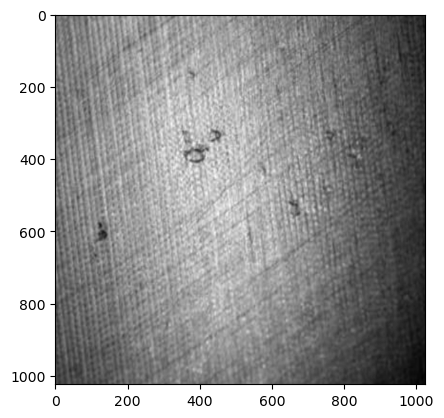

In [13]:
import numpy as np
import time
start = time.process_time()

width = 1024
height = 1024

file_name = r'/home/pratyush-g/Pictures/Machining dwarf.png'
img = Image.open(file_name)
# img = img.convert("RGB")
img = img.convert("L") # gray scale
img = img.resize((width,height), 1)
data = np.array(img)

plt.imshow(img)
plt.gray()

data = data.astype('float32') / 255.
test_img = np.reshape(data, (1,1024, 1024, 1))  # adapt this if using `channels_first` image data format
#print (test_img.shape)
decoded_imgs = autoencoder.predict(test_img)
npDecoded = decoded_imgs.reshape((1024,1024))
formatted2 = (npDecoded * 255 / np.max(npDecoded)).astype('uint8')
decoded = Image.fromarray(formatted2)
npImg = data
npImg = npImg.reshape((1024,1024))
img = Image.fromarray(npImg)
#err = mse(img, formatted2)
#print(err)
#value,dd = cal_ssim(img,decoded)    
value,dd = structural_similarity(npImg, npDecoded, data_range=npImg.max() - npDecoded.min(), full=True)  
if value<0.86:
    ok = 'Defected'
else:
    ok = 'Not Defected'

print(f'ssim value is : {value}')
print(f'{file_name} is {ok}')
end = time.process_time() 
# your code here    
print(f"Inference time is {end-start} seconds")

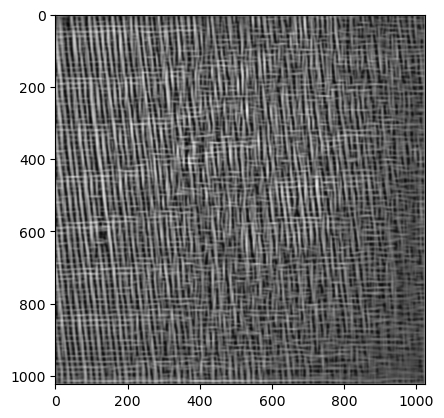

In [14]:
#plotting decoded image
plt.imshow(decoded_imgs.reshape(1024, 1024))
plt.gray()

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0 255 255   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 255 255 255   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0 

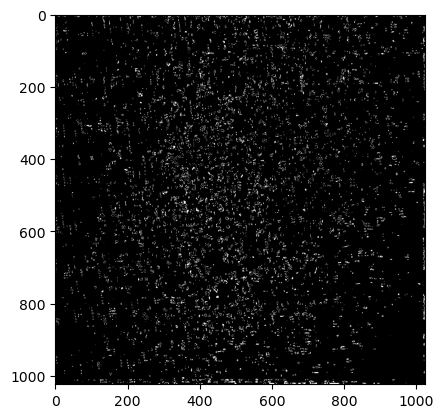

In [15]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# plotting residual map 
(score, diff) = structural_similarity(npImg, npDecoded, data_range=npImg.max() - npDecoded.min(), full=True)
diff = (diff * 255).astype("uint8")
s_map = ssim_seg(npImg, npDecoded)
mask= seg_mask(diff, threshold = 230)
print(mask)
plt.imshow(mask)
plt.gray()

In [16]:
h,w = mask.shape
print(mask.shape)

def cc(img):
  
  r = np.zeros((h,w))
  k = 1
  for i in range(1,h):

    for j in range(1,w):

      if img[i,j] == 255:

        if ((img[i,j-1] == 0) and (img[i-1,j] == 0)):
          r[i,j] = k
          k += 1

        elif ((img[i,j-1] == 255) and (img[i-1,j] == 0)):
          r[i,j] = r[i,j-1]
        
        elif ((img[i,j-1] == 0) and (img[i-1,j] == 255)):
          r[i,j] = r[i-1,j]

        elif ((img[i,j-1] == 255) and (img[i-1,j] == 255)):
          r[i,j] = r[i-1,j]
          if r[i,j-1]!=r[i-1,j]:
            r[i,j-1] = r[i-1,j]

  return r

(1024, 1024)


[0.0000e+00 1.0000e+00 2.0000e+00 3.0000e+00 4.0000e+00 5.0000e+00
 7.0000e+00 8.0000e+00 9.0000e+00 1.1000e+01 1.2000e+01 1.3000e+01
 1.4000e+01 1.5000e+01 1.6000e+01 1.7000e+01 1.8000e+01 2.0000e+01
 2.1000e+01 2.2000e+01 2.3000e+01 2.4000e+01 2.6000e+01 2.7000e+01
 2.8000e+01 2.9000e+01 3.0000e+01 3.1000e+01 3.2000e+01 3.3000e+01
 3.4000e+01 3.5000e+01 3.6000e+01 3.7000e+01 3.8000e+01 3.9000e+01
 4.0000e+01 4.3000e+01 4.4000e+01 4.5000e+01 4.6000e+01 4.8000e+01
 4.9000e+01 5.0000e+01 5.1000e+01 5.2000e+01 5.3000e+01 5.4000e+01
 5.5000e+01 5.6000e+01 5.7000e+01 5.8000e+01 5.9000e+01 6.0000e+01
 6.1000e+01 6.2000e+01 6.3000e+01 6.4000e+01 6.5000e+01 6.6000e+01
 6.7000e+01 6.8000e+01 6.9000e+01 7.0000e+01 7.1000e+01 7.2000e+01
 7.3000e+01 7.4000e+01 7.5000e+01 7.6000e+01 7.8000e+01 7.9000e+01
 8.1000e+01 8.2000e+01 8.3000e+01 8.4000e+01 8.5000e+01 8.6000e+01
 8.7000e+01 8.8000e+01 8.9000e+01 9.0000e+01 9.3000e+01 9.4000e+01
 9.5000e+01 9.6000e+01 9.8000e+01 9.9000e+01 1.0000e+02 1.0200

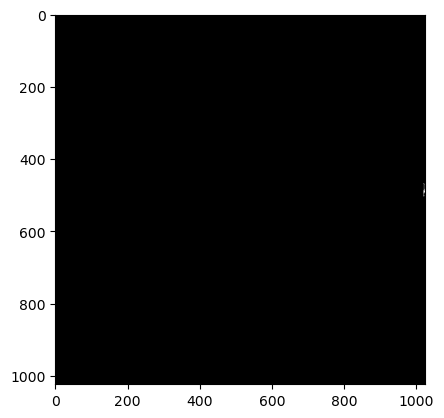

In [17]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

a, b = mask.shape
r = cc(mask)
#print(r)
elemnets,freq=np.unique(r,return_counts=True)
print(elemnets, freq)
# #x = freq.sort()
# #x = x[-3:-2]
# #print(x)
# # elements = elemnets[x[1]]
# # pri1nt(elements)
# #x = numpy.amax(r, axis=None)
# freq = sorted(freq)
# print(freq)
# #freq = freq[-3:0]
# print(elemnets[freq := freq[-2]])

from collections import Counter

ctr = Counter(r.ravel())
second_most_common_value, its_frequency = ctr.most_common(2)[1]

print(second_most_common_value)

for i in range(a):
    for j in range(b):
        if r[i,j] == second_most_common_value:
            r[i][j] = 255
        else:
            r[i][j] = 0

plt.imshow(r)
plt.gray()

In [ ]:
x = r'/home/pratyush-g/Pictures/FishScale.png'
img = Image.open(x)

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title('Image')
plt.subplot(1,4,2)
plt.imshow(decoded, cmap = 'gray')
plt.title('Decoded')
plt.subplot(1,4,3)
plt.imshow(mask, cmap='gray')
plt.title('SSIM_Map')
# plt.subplot(1,4,4)
# plt.imshow(r, cmap = 'gray')
# plt.title('Defect')

In [ ]:
#-----------------------------
# Find Canny edges
edged = cv2.Canny(mask, 30, 200)
e = edged.copy()
# Finding Contours  Use a copy of the image e.g. edged.copy() since findContours alters the image
contours, hierarchy = cv2.findContours(e,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours found = " + str(len(contours)))
# Draw all contours (-1 signifies drawing all contours)
np=cv2.cvtColor(npImg,cv2.COLOR_GRAY2RGB)
img_=cv2.cvtColor(np,cv2.COLOR_RGB2HSV)
cv2.drawContours(img_, contours, -1, (1,200,287), 6)
im=cv2.cvtColor(img_,cv2.COLOR_HSV2RGB)
im = (im * 255).astype("uint8")
plt.imshow(im)
#-----------------------------
#plotting segmented defect on original image